# Time Series Forecasting with Scikit-learn

Goals:

- Introduce tabularization of time-series data to use
- Explore the use of Quantile Regression with Gradient Boosting models to estimate uncertainties in predictions;
- Alternatively, estimate uncertainties with the conformal prediction methods of `MAPIE`;
- Explore different ways to evaluate the quality of our models;
- Recursively compute forecast for a pre-defined forecasting horizon using `sktime`.

First let's check that the following libraries are installed.

Note, a large fraction of this tutorial does not need `mapie`, `sktime` and `seaborn`.

In [1]:
%pip install -q scikit-learn matplotlib pandas mapie sktime seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sklearn
import matplotlib
import pandas

sklearn.__version__

'1.2.2'

The following cell is not necessarily needed but can help avoid some slowdowns when running this notebooks on some machines.

In [3]:
import threadpoolctl
import joblib


n_physical_cpus = joblib.cpu_count(only_physical_cores=True)
threadpoolctl.threadpool_limits(limits=n_physical_cpus);
threadpoolctl.threadpool_info()

[{'user_api': 'openmp',
  'internal_api': 'openmp',
  'prefix': 'libomp',
  'filepath': '/Users/ogrisel/mambaforge/envs/dev/lib/python3.11/site-packages/sklearn/.dylibs/libomp.dylib',
  'version': None,
  'num_threads': 8},
 {'user_api': 'blas',
  'internal_api': 'openblas',
  'prefix': 'libopenblas',
  'filepath': '/Users/ogrisel/mambaforge/envs/dev/lib/libopenblas.0.dylib',
  'version': '0.3.21',
  'threading_layer': 'openmp',
  'architecture': 'VORTEX',
  'num_threads': 8},
 {'user_api': 'openmp',
  'internal_api': 'openmp',
  'prefix': 'libomp',
  'filepath': '/Users/ogrisel/mambaforge/envs/dev/lib/libomp.dylib',
  'version': None,
  'num_threads': 8}]

## Data exploration on the Bike Sharing Demand dataset

We start by loading the data from the OpenML repository.

In [4]:
from sklearn.datasets import fetch_openml

bike_sharing = fetch_openml(
    "Bike_Sharing_Demand", version=2, as_frame=True, parser="pandas"
)
df = bike_sharing.frame
count = df["count"]

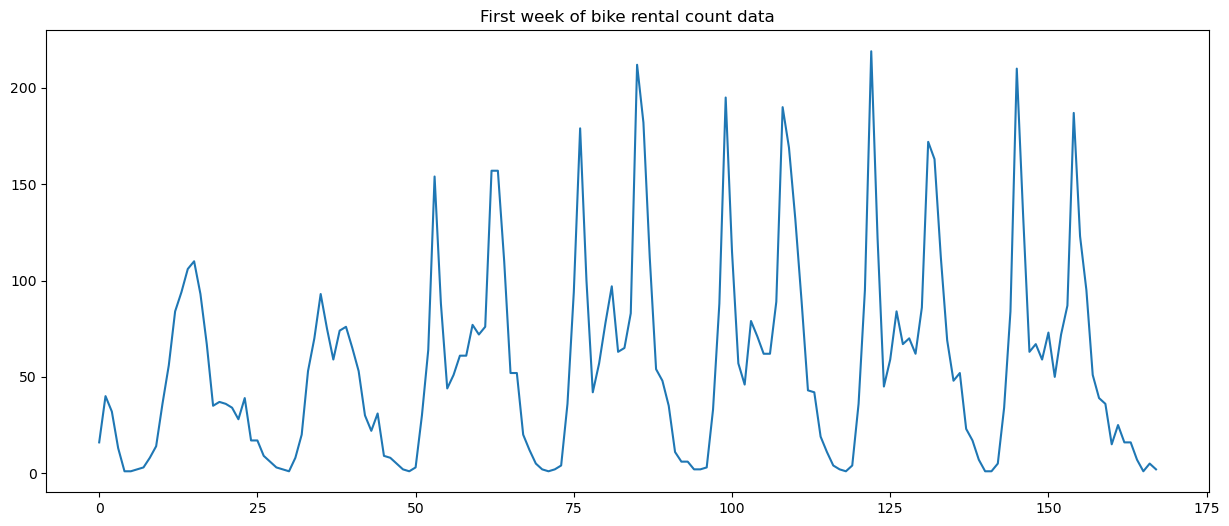

In [5]:
import matplotlib.pyplot as plt


count[:7 * 24].plot(figsize=(15, 6))
_ = plt.title("First week of bike rental count data")

In [6]:
count.describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: count, dtype: float64

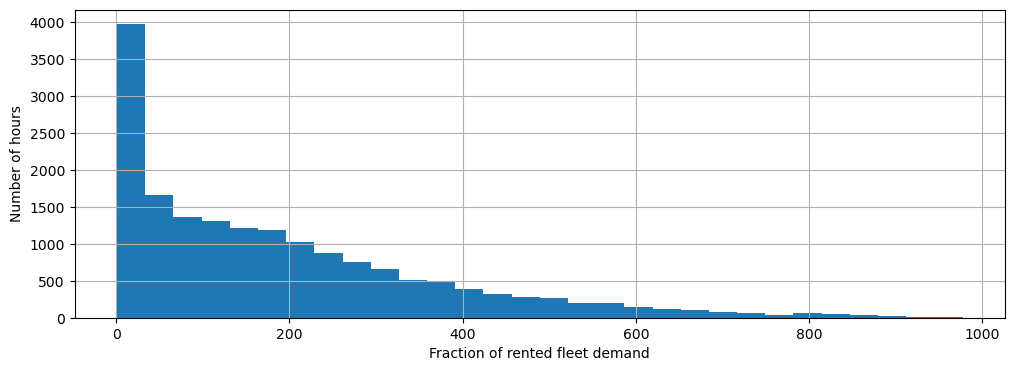

In [7]:
fig, ax = plt.subplots(figsize=(12, 4))
count.hist(bins=30, ax=ax)
_ = ax.set(
    xlabel="Fraction of rented fleet demand",
    ylabel="Number of hours",
)

## Time-series Forecasting via Tabularization

Let's consider the problem of predicting the demand at the next hour given past demands.

Since the demand is a continuous variable, one could intuitively use any regression model.

However we don't have the usual `(X_train, y_train)` dataset.

Instead we just have `y_train` demand data sequentially organized by time.


**TODO** draw a nice diagram here!

In [8]:
count.tail(10)

17369    247
17370    315
17371    214
17372    164
17373    122
17374    119
17375     89
17376     90
17377     61
17378     49
Name: count, dtype: int64

In [9]:
import pandas as pd

lagged_df = pd.concat(
    [
        count,
        count.shift(1).rename("lagged_count_1h"),
        count.shift(2).rename("lagged_count_2h"),
        count.shift(3).rename("lagged_count_3h"),
        count.shift(24).rename("lagged_count_1d"),
        count.shift(24 + 1).rename("lagged_count_1d_1h"),
        count.shift(7 * 24).rename("lagged_count_7d"),
        count.shift(7 * 24 + 1).rename("lagged_count_7d_1h"),
        count.shift(1).rolling(24).mean().rename("lagged_mean_24h"),
        count.shift(1).rolling(24).max().rename("lagged_max_24h"),
        count.shift(1).rolling(24).min().rename("lagged_min_24h"),
        count.shift(1).rolling(7 * 24).mean().rename("lagged_mean_7d"),
        count.shift(1).rolling(7 * 24).max().rename("lagged_max_7d"),
        count.shift(1).rolling(7 * 24).min().rename("lagged_min_7d"),
    ],
    axis="columns",
)
lagged_df.tail(10)

,count,lagged_count_1h,lagged_count_2h,lagged_count_3h,lagged_count_1d,lagged_count_1d_1h,lagged_count_7d,lagged_count_7d_1h,lagged_mean_24h,lagged_max_24h,lagged_min_24h,lagged_mean_7d,lagged_max_7d,lagged_min_7d
17369,247,203.0,224.0,157.0,160.0,169.0,70.0,135.0,93.500000,224.0,1.0,67.732143,271.0,1.0
17370,315,247.0,203.0,224.0,138.0,160.0,46.0,70.0,97.125000,247.0,1.0,68.785714,271.0,1.0
17371,214,315.0,247.0,203.0,133.0,138.0,33.0,46.0,104.500000,315.0,1.0,70.386905,315.0,1.0
17372,164,214.0,315.0,247.0,123.0,133.0,33.0,33.0,107.875000,315.0,1.0,71.464286,315.0,1.0
17373,122,164.0,214.0,315.0,125.0,123.0,26.0,33.0,109.583333,315.0,1.0,72.244048,315.0,1.0
17374,119,122.0,164.0,214.0,102.0,125.0,26.0,26.0,109.458333,315.0,1.0,72.815476,315.0,1.0
17375,89,119.0,122.0,164.0,72.0,102.0,18.0,26.0,110.166667,315.0,1.0,73.369048,315.0,1.0
17376,90,89.0,119.0,122.0,47.0,72.0,23.0,18.0,110.875000,315.0,1.0,73.791667,315.0,1.0
17377,61,90.0,89.0,119.0,36.0,47.0,22.0,23.0,112.666667,315.0,1.0,74.190476,315.0,1.0
17378,49,61.0,90.0,89.0,49.0,36.0,12.0,22.0,113.708333,315.0,1.0,74.422619,315.0,1.0


Whatch out however, the first lines have undefined values because their own past is unknown. This depends on how much lag we used:

In [10]:
lagged_df.head(10)

,count,lagged_count_1h,lagged_count_2h,lagged_count_3h,lagged_count_1d,lagged_count_1d_1h,lagged_count_7d,lagged_count_7d_1h,lagged_mean_24h,lagged_max_24h,lagged_min_24h,lagged_mean_7d,lagged_max_7d,lagged_min_7d
0,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,32,40.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13,32.0,40.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,13.0,32.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,1.0,13.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2,1.0,1.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,3.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,14,8.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can now separate the lagged features in a matrix `X` and the target variable (the counts to predict) in an array of the same first dimension `y`.

In [11]:
lagged_df = lagged_df.dropna()

In [12]:
X = lagged_df.drop("count", axis="columns")
y = lagged_df["count"]

In [13]:
X.shape

(17210, 13)

In [14]:
y.shape

(17210,)

## Naive Regression of the Next Hour Bike Demand

Let's randomly split our tabularized dataset to train a gradient boosting regression tree (GBRT) model and evaluate it using the [Mean Absolute Percentage Error](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-percentage-error).

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = HistGradientBoostingRegressor().fit(X_train, y_train)

In [16]:
from sklearn.metrics import mean_absolute_percentage_error


y_pred = model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

0.38580218787003084

### Questions

- Why this way of evaluating the predictive performance of our model naive?
    - Hint: this train-test split is only valid for *independent and identically distributed data*.
- What should be done instead?

## Proper Next Hour Forecasting Evaluation

Let's use a proper evaluation splitting strategies that takes into account the temporal structure of the dataset to **evaluate our model's ability to predict data points in the future** (to avoid cheating by reading values from the lagged features in the training set).


![TimeSeriesSplit](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_013.png)

The above diagram has 4 splits, a gap of 0 time steps and no limit on the train size.

In [17]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=3,            # to keep the notebook fast enough on common laptops
    gap=48,                # 2 days data gap between train and test
    max_train_size=10000,  # quite arbitrary, to keep train sets of comparable sizes
    test_size=3000,        # need at lest this to hope for 2 or 3 digits of precision in scores
)

In [18]:
all_splits = list(ts_cv.split(X, y))
len(all_splits)

3

In [19]:
train_idx, test_idx = all_splits[0]
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

model = HistGradientBoostingRegressor().fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

0.44300751539296973

The error rate of this model is better than our naive shuffling train-test split. This is quite expected but maybe the first split is easier to predict (more regular) than the others. Let's assess this variability of our error evaluation with proper cross-validation:

In [20]:
from sklearn.model_selection import cross_val_score


cv_mape_scores = -cross_val_score(model, X, y, cv=ts_cv, scoring="neg_mean_absolute_percentage_error")
cv_mape_scores

array([0.44300752, 0.27772182, 0.3697178 ])

The variability accross splits is quite large! In a real life setting it would be advised to use more splits to better assess the variability. Let's report the mean CV scores and their standard deviation from now on.

In [21]:
print(f"CV MAPE: {cv_mape_scores.mean():.3f} ± {cv_mape_scores.std():.3f}")

CV MAPE: 0.363 ± 0.068


To get a finer evaluation of our models we can compute and report several cross-validation metrics at once using a dedicated helper function:

In [22]:
import numpy as np
from time import perf_counter
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_pinball_loss
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error


def evaluate(model, X, y, cv):
    def score_func(estimator, X, y):
        y_pred = estimator.predict(X)
        return {
            "mean_absolute_percentage_error": mean_absolute_percentage_error(y, y_pred),
            "root_mean_squared_error": np.sqrt(mean_squared_error(y, y_pred)),
            "mean_absolute_error": mean_absolute_error(y, y_pred),
            "mean_pinball_05_loss": mean_pinball_loss(y, y_pred, alpha=0.05),
            "mean_pinball_50_loss": mean_pinball_loss(y, y_pred, alpha=0.50),
            "mean_pinball_95_loss": mean_pinball_loss(y, y_pred, alpha=0.95),
        }
    tic = perf_counter()
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=score_func,
    )
    toc = perf_counter()
    for key, value in cv_results.items():
        if key.startswith("test_"):
            print(f"{key[5:]}: {value.mean():.3f} ± {value.std():.3f}")
    print(f"\ndone in {toc - tic:.3f} s")

In [23]:
from sklearn.ensemble import HistGradientBoostingRegressor


gbrt_mse = HistGradientBoostingRegressor(loss="squared_error")
evaluate(gbrt_mse, X, y, cv=ts_cv)

mean_absolute_percentage_error: 0.363 ± 0.068
root_mean_squared_error: 62.343 ± 3.523
mean_absolute_error: 39.088 ± 2.268
mean_pinball_05_loss: 17.700 ± 1.275
mean_pinball_50_loss: 19.544 ± 1.134
mean_pinball_95_loss: 21.388 ± 2.363

done in 5.522 s


In [24]:
gbrt_poisson = HistGradientBoostingRegressor(loss="poisson")
evaluate(gbrt_poisson, X, y, cv=ts_cv)

mean_absolute_percentage_error: 0.316 ± 0.069
root_mean_squared_error: 64.186 ± 4.050
mean_absolute_error: 39.307 ± 2.808
mean_pinball_05_loss: 16.669 ± 1.541
mean_pinball_50_loss: 19.653 ± 1.404
mean_pinball_95_loss: 22.638 ± 2.983

done in 5.374 s


### Analysis

Compare the results of those first two models, what do you observe?

- which model has the best MAPE?
- which model has the best RMSE?
- in your opinion, since the `squared_error` model directly optimize for the RMSE objective, do you expect to always reach the best RMSE? Why?

### Exercise: baseline (generalized) linear models

- Evaluate `sklearn.linear_model.Ridge` and `sklearn.linear_model.PoissonRegressor` on the previous feature array. Here the data has many more samples than features so it is advised to use a low enough value for the regularization parameter `alpha` of both models, e.g. `alpha=0.0001` but feel free to try other values.
- For `Ridge`, it is recommended to use `solver="lsqr"` which has proven to be more numerically stable (and fast) than alternatives on this dataset.
- Which of the 2 models performs the best in terms of MAPE or Mean Squared Error?
- Are those models competitive in terms of training speed and cross-validated metrics compared to the tree based models?



In [25]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import PoissonRegressor


# TODO put your code here

















### Solution

In [26]:
from sklearn.linear_model import Ridge


evaluate(Ridge(alpha=1e-4, solver="lsqr"), X, y, cv=ts_cv)

mean_absolute_percentage_error: 0.649 ± 0.125
root_mean_squared_error: 66.701 ± 3.696
mean_absolute_error: 43.171 ± 3.010
mean_pinball_05_loss: 21.547 ± 1.948
mean_pinball_50_loss: 21.585 ± 1.505
mean_pinball_95_loss: 21.624 ± 1.533

done in 0.016 s


In [27]:
from sklearn.linear_model import PoissonRegressor


evaluate(PoissonRegressor(alpha=1e-4), X, y, cv=ts_cv)

mean_absolute_percentage_error: 5.638 ± 1.625
root_mean_squared_error: 212.824 ± 29.798
mean_absolute_error: 162.238 ± 24.538
mean_pinball_05_loss: 54.570 ± 9.235
mean_pinball_50_loss: 81.119 ± 12.269
mean_pinball_95_loss: 107.668 ± 26.722

done in 0.014 s


We observe that the `PoissonRegressor` model is much worse than the `Ridge` model when trained on the raw features but even the latter is not very good (e.g. a bit lower than 60% MAPE), this is much worse than the Gradient Boosting based models. One reason could be that tree-based model can naturally model non-linear statistical association between the raw `X` features and the `y` target values.

**Note**: the solver for `PoissonRegressor` does not seem to work at all the raw features. I suspect ill-conditioning of the resulting optimization problem causing the `l-BFGS` solver to fail (silently!) in this case. There is work in progress to plug alternative solvers for this estimator in scikit-learn.


## Non-linear Feature Engineering with `SplineTransformer`

Let's now consider a non-linear feature transformation (expansion) using spline functions. We hope to make the combination (spline transformer + linear model) more expressive than a linear model trained directly on the raw features.


Here is are the dimensions of the feature matrix before and after transformation by the `SplineTransformer` of scikit-learn:

In [28]:
X.shape

(17210, 13)

In [29]:
from sklearn.preprocessing import SplineTransformer


SplineTransformer(n_knots=10, degree=3).fit_transform(X).shape

(17210, 156)


You can observe that the spline-based transformation created many more derived features than originally. With this additional expressive power, one could hope that the models are no longer under fitting.

Each input feature is expanded into several features via a polynomial transformation (depending on the number of spline knots and degrees). Contrary to traditional polynomial transformation, splines features are bounded and non-monotonic:

![Spline Features (4 knots)](https://scikit-learn.org/stable/_images/sphx_glr_plot_polynomial_interpolation_002.png)


### Exercise

- Define and evaluate a pipeline of `sklearn.preprocessing.SplineTransformer` and `sklearn.linear_model.PoissonRegressor` on the same problem.
- You can use the `sklearn.pipeline.make_pipeline` function to combine the two estimators into a compound non-linear regression model that does the spline expansion internally.


**Note**: the current solver of `PoissonRegressor` (L-BFGS) is known to have trouble on this kind of features but I don't have a good solution for now, feel free to keep `max_iter=100` and silence the warning hoping that convergence is good enough.

- What do you observe?
- Are this compound model better than fitting `sklearn.linear_model.PoissonRegressor`  directly on `X` and `y`


In [30]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import make_pipeline


# TODO: put your code here




















### Solution

In [31]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import make_pipeline


pipeline = make_pipeline(
    SplineTransformer(n_knots=12, degree=3),
    PoissonRegressor(alpha=1e-6, max_iter=300),
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)
    evaluate(pipeline, X, y, cv=ts_cv)

mean_absolute_percentage_error: 0.404 ± 0.074
root_mean_squared_error: 89.904 ± 27.718
mean_absolute_error: 54.856 ± 18.491
mean_pinball_05_loss: 16.310 ± 2.441
mean_pinball_50_loss: 27.428 ± 9.245
mean_pinball_95_loss: 38.546 ± 19.961

done in 1.120 s


## Using Neural Networks

We can also compare this to another smooth non-linear model, namely a fully-connected feed forward neural network traditionally called a Multi Layer Perceptron.

This model is quite sensitive to hyper-parameter settings and to input feature scaling. Here we use `QuantileTransformer` which usually works quite well for MLPs. We keep the size small enough to keep the runtime acceptable while reaching comparable performance to our spline-base pipeline.

In [32]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.neural_network import MLPRegressor


mlp_pipeline = make_pipeline(
    QuantileTransformer(),
    MLPRegressor(solver="lbfgs", hidden_layer_sizes=(100, 100), max_iter=300),
)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)
    evaluate(mlp_pipeline, X, y, cv=ts_cv)

mean_absolute_percentage_error: 0.379 ± 0.070
root_mean_squared_error: 60.910 ± 3.998
mean_absolute_error: 38.481 ± 3.706
mean_pinball_05_loss: 18.844 ± 3.387
mean_pinball_50_loss: 19.241 ± 1.853
mean_pinball_95_loss: 19.637 ± 1.493

done in 33.756 s


Unfortunately the `MLPRegressor` does not accept the Poisson loss at this time (only the squared error loss used by default for regression).

Note that our MLP predictive performance is still lower than our gradient boosting based models while being much more finicky to train (many important hyper-parameters, input feature scaling options) and much slower to train on CPUs than either spline-based linear models or tree-based models. Therefore I would not recommend scikit-learn MLPs for this class of problems.

If we would like to benefit from the full flexibility of architecture design using PyTorch and its GPU acceleration while keeping the compatibility with scikit-learn pipeline and evaluation tools, it would be possible to use [skorch](https://github.com/skorch-dev/skorch).

Alternatively, we could also benefit from neural network architectures that are auto-regressive in nature (e.g. causal convolutional networks or causal transformers with positional encodings) and by-pass the "Tabularization" feature engineering entirely.

## Modeling Predictive Uncertainty via Quantile Regression

Instead of modeling the expected value of the distribution of $Y|X$ like the least squares and Poisson losses do, one could try to estimate quantiles of that conditional distribution.

$Y|X=x_i$ is expected to be a random variable for a given data point $x_i$ because we expect that the number of rentals cannot be 100% accurately predicted from the features. It can be influenced by other variables not properly captured by the existing laggued features. For instance wether or not it will rain in the next hour cannot be fully be anticipated from the past hours bike rental data. This is what we call **aleatoric** uncertainty.

Quantile regression makes it possible to give a finer description of that distribution without making strong assumptions on its shape.

The conditional 5th percentile (a.k.a. 0.05-quantile) can be estimated with:

In [33]:
gbrt_percentile_05 = HistGradientBoostingRegressor(loss="quantile", quantile=0.05)
evaluate(gbrt_percentile_05, X, y, cv=ts_cv)

mean_absolute_percentage_error: 0.405 ± 0.014
root_mean_squared_error: 145.563 ± 20.868
mean_absolute_error: 92.476 ± 16.235
mean_pinball_05_loss: 5.874 ± 0.925
mean_pinball_50_loss: 46.238 ± 8.117
mean_pinball_95_loss: 86.602 ± 15.310

done in 5.824 s


The conditional median (0.50-quantile) can be estimated with:

In [34]:
gbrt_median = HistGradientBoostingRegressor(loss="quantile", quantile=0.5)
evaluate(gbrt_median, X, y, cv=ts_cv)

mean_absolute_percentage_error: 0.324 ± 0.059
root_mean_squared_error: 64.643 ± 3.808
mean_absolute_error: 39.854 ± 3.167
mean_pinball_05_loss: 17.147 ± 1.067
mean_pinball_50_loss: 19.927 ± 1.584
mean_pinball_95_loss: 22.706 ± 3.131

done in 6.311 s


And finally the 0.95 quantile:

In [35]:
gbrt_percentile_95 = HistGradientBoostingRegressor(loss="quantile", quantile=0.95)
evaluate(gbrt_percentile_95, X, y, cv=ts_cv)

mean_absolute_percentage_error: 1.067 ± 0.270
root_mean_squared_error: 99.560 ± 8.746
mean_absolute_error: 72.009 ± 6.143
mean_pinball_05_loss: 62.901 ± 7.443
mean_pinball_50_loss: 36.005 ± 3.071
mean_pinball_95_loss: 9.109 ± 1.305

done in 5.896 s


### Questions

- Look at the previous three models scores. Which model minimizes best the:
    - `mean_absolute_error`
    - `mean_pinball_05_loss`
    - `mean_pinball_50_loss`
    - `mean_pinball_95_loss`
    on the set?


## A Qualitative Look at the Predictions

In [36]:
all_splits = list(ts_cv.split(X, y))
train_idx, test_idx = all_splits[0]


X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [37]:
max_iter = 50
gbrt_mean_poisson = HistGradientBoostingRegressor(loss="poisson", max_iter=max_iter)
gbrt_mean_poisson.fit(X_train, y_train)
mean_predictions = gbrt_mean_poisson.predict(X_test)

gbrt_median = HistGradientBoostingRegressor(loss="quantile", quantile=0.5, max_iter=max_iter)
gbrt_median.fit(X_train, y_train)
median_predictions = gbrt_median.predict(X_test)

gbrt_percentile_5 = HistGradientBoostingRegressor(loss="quantile", quantile=0.05, max_iter=max_iter)
gbrt_percentile_5.fit(X_train, y_train)
percentile_5_predictions = gbrt_percentile_5.predict(X_test)

gbrt_percentile_95 = HistGradientBoostingRegressor(loss="quantile", quantile=0.95, max_iter=max_iter)
gbrt_percentile_95.fit(X_train, y_train)
percentile_95_predictions = gbrt_percentile_95.predict(X_test)

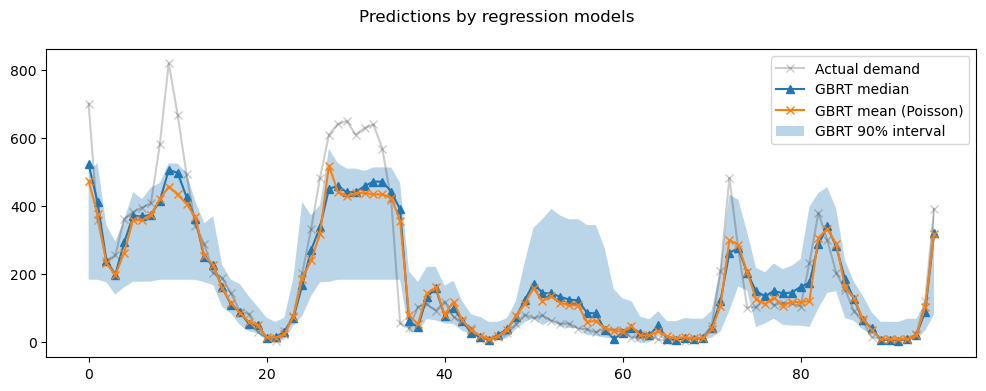

In [38]:
last_hours = slice(-96, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by regression models")
ax.plot(
    y_test.values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    median_predictions[last_hours],
    "^-",
    label="GBRT median",
)
ax.plot(
    mean_predictions[last_hours],
    "x-",
    label="GBRT mean (Poisson)",
)
ax.fill_between(
    np.arange(96),
    percentile_5_predictions[last_hours],
    percentile_95_predictions[last_hours],
    alpha=0.3,
    label="GBRT 90% interval"
)
_ = ax.legend()

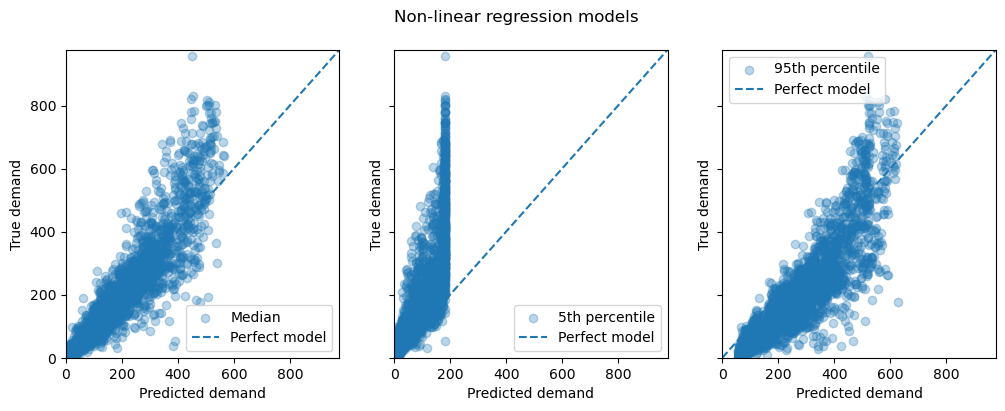

In [39]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    median_predictions,
    percentile_5_predictions,
    percentile_95_predictions,
]
labels = [
    "Median",
    "5th percentile",
    "95th percentile",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(pred, y_test.values, alpha=0.3, label=label)
    ax.plot([0, y.max()], [0, y.max()], "--", label="Perfect model")
    ax.set(
        xlim=(0, y.max()),
        ylim=(0, y.max()),
        xlabel="Predicted demand",
        ylabel="True demand",
    )
    ax.legend()

plt.show()

### Assessing Quantile Calibration by Measuring the Effective Coverage

We can evaluate if our quantile estimates are well calibrated by assessing

In [40]:
(median_predictions > y_test).mean()

0.5246666666666666

In [41]:
(percentile_5_predictions > y_test).mean()

0.081

In [42]:
(percentile_95_predictions > y_test).mean()

0.8823333333333333

In [43]:
np.logical_and(
    percentile_5_predictions < y_test,
    percentile_95_predictions > y_test,
).mean()

0.8013333333333333

### Questions

- Which of the previous quantile estimates appear well-calibrated?
- Is the uncertainty band estimated between the low and high quantiles too wide or too narrow?

### Analysis

The pinball loss is guaranteed to be minimized by models that estimate the quantiles perfectly. However in practice this is an asymptotic property (with access to an infinite number of data points).

When the number of samples is limited, models with the same pinball loss can trade calibration for ranking power: one extreme case would be to compute the quantiles of `y_train` independently of `X_train`. This will yield a well calibrated quantile estimator with an worseless ranking power.

Therefore one cannot always trust the prediction intervals returned by quantiles estimators with a non-zero pinball loss.

**Exercise**: try to plot such reliability curve for the models above using `numpy` and `matplotlib`.

### Possible Ways to Improve Calibration

As usual, we can probably improve our estimators by:

- collecting more data-points (in case the model is overfitting);
- better tuning of the model hyper-parameters (for instance you could try `max_iter=300`, `max_leaf_nodes=64`) and make sure the model is not over-fitting too much (e.g. by plotting the validation losses per boosting iteration and using early stopping);
- engineering more predictive features from the same data. This is especially useful for linear quantile regression (not covered in this tutorial);
- try other kinds of quantile regression models, for instance Quantile Forests (see below).

It is also possible to make uncertainty itself estimation easier by reducing the randomness in the forecasting problem, for instance by including more informative features (larger lagged feature windows or external context variables like weather data).

See also the following reference 

- [Beyond Pinball Loss: Quantile Methods for Calibrated Uncertainty Quantification](https://arxiv.org/abs/2011.09588) by Youngseog Chung, Willie Neiswanger, Ian Char, Jeff Schneider.

Alternatively, it's also possible to try uncertainty estimation based on Bayesian estimation or conformal predictions. For the latter, [MAPIE](https://github.com/scikit-learn-contrib/MAPIE) provides an implemetnation based on recent work on conformal prediction methods and estimates both aleatoric and epistemic uncertainty at the same time:

- aleatoric uncertainty stems from the fact that not all `y` can ever be predicted from the limitted information available in `X` (e.g. lack of wheather data for the next hour),
- epistemic uncertainty stems from the fact that we build our estimators from a finite sample of data points that do not cover all the possible situations.

Aleatoric uncertainty is what remains when the number of data-points goes to infinity.

### Quantile Forests

Quantile Forests are an alternative way to estimate prediction intervals for regression tasks. The [quantile-forest](https://github.com/zillow/quantile-forest/) package provides a maintained implementation of this method:

In [48]:
%pip install -q quantile-forest

Note: you may need to restart the kernel to use updated packages.


In [49]:
from sklearn.ensemble import RandomForestRegressor
from quantile_forest import RandomForestQuantileRegressor


min_samples_leaf = 300
rf = RandomForestRegressor(criterion="poisson", min_samples_leaf=min_samples_leaf)
rf.fit(X_train, y_train)
mean_predictions = rf.predict(X_test)

qrf = RandomForestQuantileRegressor(min_samples_leaf=min_samples_leaf)
qrf.fit(X_train, y_train)
y_pred = qrf.predict(X_test, quantiles=[0.05, 0.95])
percentile_5_predictions = y_pred[:, 0]
percentile_95_predictions = y_pred[:, 1]

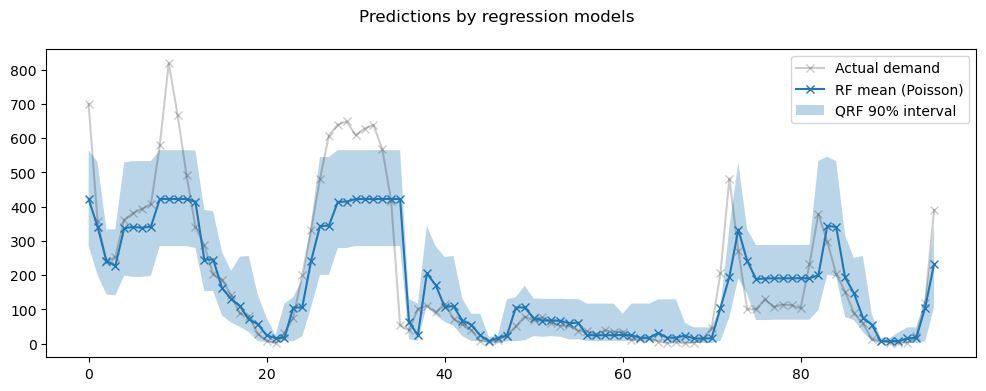

In [50]:
last_hours = slice(-96, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by regression models")
ax.plot(
    y_test.values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    mean_predictions[last_hours],
    "x-",
    label="RF mean (Poisson)",
)
ax.fill_between(
    np.arange(96),
    percentile_5_predictions[last_hours],
    percentile_95_predictions[last_hours],
    alpha=0.3,
    label="QRF 90% interval"
)
_ = ax.legend()

In [51]:
(percentile_5_predictions > y_test).mean()

0.060333333333333336

In [52]:
(percentile_95_predictions > y_test).mean()

0.9036666666666666

In [53]:
np.logical_and(
    percentile_5_predictions < y_test,
    percentile_95_predictions > y_test,
).mean()

0.8293333333333334

This QRF model seems to be better calibrated than our GBRT quantile regressor models but it still under estimates the inter-quantile width and the upper quantile in particular. Tuning the hyper-parameters might help achieve better results.

### Exercise: Unconditional Quantiles as Baseline

Estimate 90%-wide quantiles on `y_train` (independently of `X_train`) and compute calibration via coverage on `y_test`.

In [54]:
from numpy import quantile


# TODO: put your code here









### Solution

In [55]:
from numpy import quantile

fixed_05_quantile, fixed_95_quantile = np.quantile(y_train, [0.05, 0.95])
fixed_05_quantile, fixed_95_quantile

(4.0, 423.0)

In [56]:
np.logical_and(
    fixed_05_quantile < y_test,
    fixed_95_quantile > y_test,
).mean()

0.831

In [57]:
mean_pinball_loss(y_test, np.full_like(y_test, fill_value=fixed_05_quantile), alpha=0.05)

8.624333333333333

In [58]:
mean_pinball_loss(y_test, np.full_like(y_test, fill_value=fixed_95_quantile), alpha=0.95)

26.398333333333344

Even this simple baseline without any ranking power is not properly callibrated according to this test set (one would need to re-rerun on all cross-validation splits to confirm). The mean pinball loss of those quantile estimates is not ridiculous but not competitive either because of the lack of ranking power.

### Quantile regression via multiclass classification

In [59]:
from scipy.interpolate import interp1d
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.utils.validation import check_is_fitted
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.utils.validation import check_consistent_length, check_array


class BinnedQuantileRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, estimator=None, n_bins=30):
        self.n_bins = n_bins
        self.estimator = estimator

    def fit(self, X, y):
        # Lightweight input validation: most of the input validation will be
        # handled by the sub estimators.
        check_consistent_length(X, y)
        self.target_binner_ = KBinsDiscretizer(
            n_bins=self.n_bins,
            strategy="quantile",
            encode="ordinal",
        )

        y_binned = self.target_binner_.fit_transform(
            np.asarray(y).reshape(-1, 1)
        ).ravel()

        # Fit the multiclass classifier to predict the binned targets from the
        # training set.
        if self.estimator is None:
            estimator = RandomForestClassifier()
        else:
            estimator = clone(self.estimator)
        self.estimator_ = estimator.fit(X, y_binned)
        return self

    def predict_quantiles(self, X, quantiles):
        check_is_fitted(self, "estimator_")
        y_proba = self.estimator_.predict_proba(X)
        thresholds = self.target_binner_.bin_edges_[0]

        y_cdf = np.zeros(shape=(X.shape[0], thresholds.shape[0]))
        y_cdf[:, 1:] = np.cumsum(y_proba, axis=1)
        
        # Build the mapper for inverse CDF mapping, from cumulated
        # probabilities to continuous prediction.
        return np.asarray(
            [interp1d(y_cdf_i, thresholds)(quantiles) for y_cdf_i in y_cdf]
        )


bqr = BinnedQuantileRegressor()
quantile_predictions = (
    bqr.fit(X_train, y_train).predict_quantiles(X_test, quantiles=[0.05, 0.5, 0.95])
)
quantile_predictions.shape

(3000, 3)

In [60]:
percentile_5_predictions = quantile_predictions[:, 0]
percentile_50_predictions = quantile_predictions[:, 1]
percentile_95_predictions = quantile_predictions[:, 2]

In [61]:
np.logical_and(
    percentile_5_predictions < y_test,
    percentile_95_predictions > y_test,
).mean()

0.901

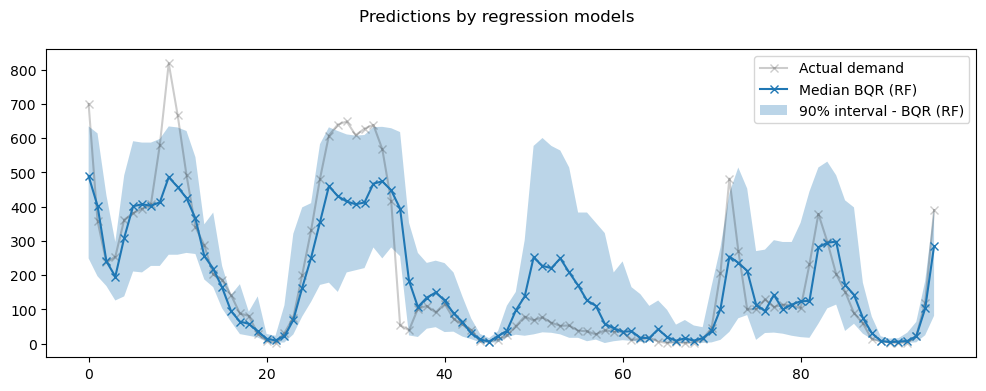

In [62]:
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by regression models")
ax.plot(
    y_test.values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    percentile_50_predictions[last_hours],
    "x-",
    label="Median BQR (RF)",
)
ax.fill_between(
    np.arange(96),
    percentile_5_predictions[last_hours],
    percentile_95_predictions[last_hours],
    alpha=0.3,
    label="90% interval - BQR (RF)"
)
_ = ax.legend()

In [63]:
from sklearn.ensemble import HistGradientBoostingClassifier


bqr_gbrt = BinnedQuantileRegressor(estimator=HistGradientBoostingClassifier())
quantile_predictions = (
    bqr_gbrt.fit(X_train, y_train).predict_quantiles(X_test, quantiles=[0.05, 0.5, 0.95])
)
quantile_predictions.shape

(3000, 3)

In [64]:
percentile_5_predictions = quantile_predictions[:, 0]
percentile_50_predictions = quantile_predictions[:, 1]
percentile_95_predictions = quantile_predictions[:, 2]

In [65]:
np.logical_and(
    percentile_5_predictions < y_test,
    percentile_95_predictions > y_test,
).mean()

0.7396666666666667

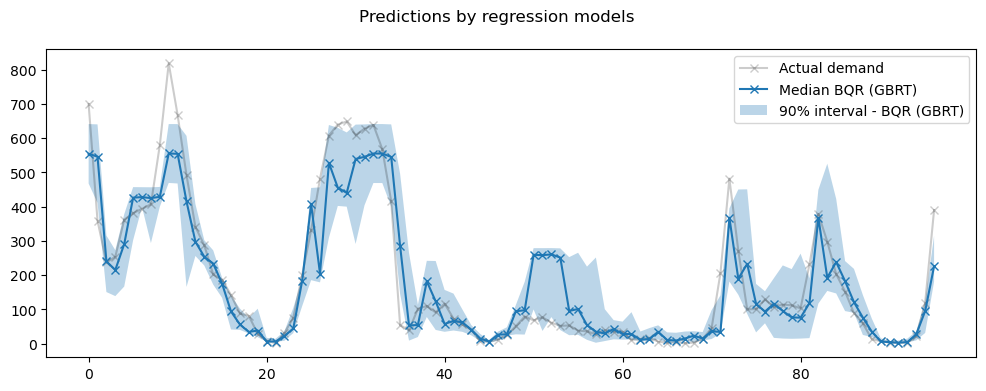

In [66]:
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by regression models")
ax.plot(
    y_test.values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    percentile_50_predictions[last_hours],
    "x-",
    label="Median BQR (GBRT)",
)
ax.fill_between(
    np.arange(96),
    percentile_5_predictions[last_hours],
    percentile_95_predictions[last_hours],
    alpha=0.3,
    label="90% interval - BQR (GBRT)"
)
_ = ax.legend()

### Exercise: Uncertainty Estimation with MAPIE

- Wrap our `HistGradientBoostingRegressor(loss="poisson")` estimator into the `mapie.regression.MapieRegressor` meta-estimators.
- Read the documentation of MAPIE linked above to predict a 90% prediction interval;
- Measure the actual coverage of that interval on a test set;
- Plot the prediction interval on the `last_hours` slice of the test set.

Questions: is this better than results obtained directly by quantile regression?

In [67]:
%pip install -q MAPIE

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from mapie.regression import MapieRegressor


# TODO: your code here



















### Solution

In [58]:
from mapie.regression import MapieRegressor
from sklearn.model_selection import TimeSeriesSplit

# mapie_cv = TimeSeriesSplit(
#     n_splits=5,
#     gap=48,
#     max_train_size=10000,
#     test_size=1000,
# )
mapie_cv = 5  # k-fold
gbrt_mean_poisson_mapie = MapieRegressor(HistGradientBoostingRegressor(loss="poisson"), cv=mapie_cv)
gbrt_mean_poisson_mapie.fit(X_train, y_train)
mean_predictions, predictions_90_pi = gbrt_mean_poisson_mapie.predict(X_test, alpha=0.1)
predictions_90_pi_low = predictions_90_pi[:, 0].ravel()
predictions_90_pi_high = predictions_90_pi[:, 1].ravel()

In [67]:
from mapie.quantile_regression import MapieQuantileRegressor


gbrt_quantile_mapie = MapieQuantileRegressor(
    estimator=HistGradientBoostingRegressor(loss="quantile", quantile=0.5, max_iter=max_iter),
    alpha=0.1,
    method="quantile",
    cv="split",
).fit(X_train, y_train)

mean_predictions, predictions_90_pi = gbrt_quantile_mapie.predict(X_test)
predictions_90_pi_low = predictions_90_pi[:, 0].ravel()
predictions_90_pi_high = predictions_90_pi[:, 1].ravel()

/Users/ogrisel/mambaforge/envs/dev/lib/python3.11/site-packages/mapie/utils.py:484: UserWarning: WARNING: The predictions of the quantile regression have issues.
The upper quantile predictions are lower
than the lower quantile predictions
at some points.
  warnings.warn(
/Users/ogrisel/mambaforge/envs/dev/lib/python3.11/site-packages/mapie/utils.py:502: UserWarning: WARNING: The predictions have issues.
The upper predictions are lower thanthe lower predictions at some points.
  warnings.warn(


In [70]:
gbrt_quantile_mapie.estimators_

[HistGradientBoostingRegressor(loss='quantile', max_iter=50, quantile=0.05),
 HistGradientBoostingRegressor(loss='quantile', max_iter=50, quantile=0.95),
 HistGradientBoostingRegressor(loss='quantile', max_iter=50, quantile=0.5)]

In [71]:
np.logical_and(
    predictions_90_pi_low < y_test,
    predictions_90_pi_high > y_test,
).mean()


0.844

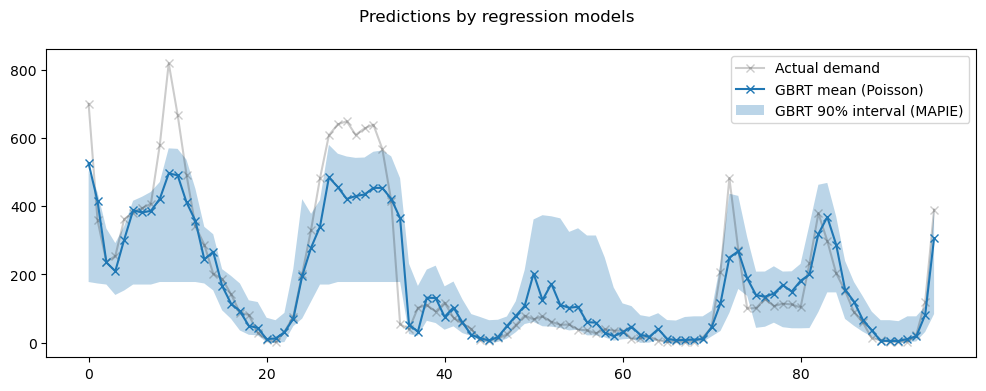

In [72]:
last_hours = slice(-96, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by regression models")
ax.plot(
    y_test.values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    mean_predictions[last_hours],
    "x-",
    label="GBRT mean (Poisson)",
)
ax.fill_between(
    np.arange(96),
    predictions_90_pi_low[last_hours],
    predictions_90_pi_high[last_hours],
    alpha=0.3,
    label="GBRT 90% interval (MAPIE)"
)
_ = ax.legend()

## Inspecting the Most Predictive Features

In this last section we redo the full pipeline with a richer lagged feature set.

We then use the `permutation_importance` tool of scikit-learn to mine which features are the most predictive.

In [68]:
lagged_df = pd.concat(
    [count]
    + [count.shift(i).rename(f"lagged_count_{i}h") for i in range(1, 48)]
    + [count.shift(7 * 24 + i).rename(f"lagged_count_7d_{i}h") for i in range(0, 48)]
    + [
        count.shift(1).rolling(24).mean().rename("lagged_mean_24h"),
        count.shift(1).rolling(24).max().rename("lagged_max_24h"),
        count.shift(1).rolling(24).min().rename("lagged_min_24h"),
        count.shift(1).rolling(7 * 24).mean().rename("lagged_mean_7d"),
        count.shift(1).rolling(7 * 24).max().rename("lagged_max_7d"),
        count.shift(1).rolling(7 * 24).min().rename("lagged_min_7d"),
    ],
    axis="columns",
).dropna()

X = lagged_df.drop("count", axis="columns")
y = lagged_df["count"]

In [69]:
X.shape

(17164, 101)

In [70]:

evaluate(HistGradientBoostingRegressor(loss="poisson", max_leaf_nodes=64, max_iter=300), X, y, cv=ts_cv)

mean_absolute_percentage_error: 0.278 ± 0.063
root_mean_squared_error: 61.840 ± 4.532
mean_absolute_error: 37.098 ± 3.414
mean_pinball_05_loss: 12.640 ± 1.228
mean_pinball_50_loss: 18.549 ± 1.707
mean_pinball_95_loss: 24.458 ± 3.642

done in 35.162 s


In [ ]:
train_idx, test_idx = next(ts_cv.split(X, y))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

gbrt_mean_poisson = HistGradientBoostingRegressor(loss="poisson", max_leaf_nodes=64, max_iter=300)
gbrt_mean_poisson.fit(X_train, y_train)

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import check_scoring


def boxplot_importances(model, X, y, scoring="r2", **kwargs):
    pi_results = permutation_importance(model, X, y, scoring=scoring, **kwargs)

    sorted_importances_idx = pi_results.importances_mean.argsort()[-15:]
    importances = pd.DataFrame(
        pi_results.importances[sorted_importances_idx].T,
        columns=X.columns[sorted_importances_idx],
    )
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title("Permutation Importances")
    ax.axvline(x=0, color="k", linestyle="--")
    ref_score = check_scoring(model, scoring)(model, X, y)
    ax.set_xlabel(f"Decrease in score (reference: {ref_score:.3f})")
    ax.figure.tight_layout()

In [ ]:
boxplot_importances(gbrt_mean_poisson, X_test, y_test, scoring="r2")

In [ ]:
from sklearn.metrics import d2_tweedie_score
from functools import partial
from sklearn.metrics import make_scorer

d2_poisson_score = make_scorer(partial(d2_tweedie_score, power=1))
boxplot_importances(
    gbrt_mean_poisson, X_test, y_test, scoring=d2_poisson_score
)

Both plot return approximately the same features as most predictive feature sets. Precomputed feature aggregates over meaningful windows (`mean`, `min`, `max`) seem to be quite useful for this model. Furthermore the lag features `1d`, `7d_0h` are strongly indicative that the model could detect relevant cyclic business patterns in the data (daily and weekly behavior).

One could conduct similar analysis for the quantile regressors using the `pinball_loss` by passing the `alpha` parameter to `make_scorer`.

Note: one could have efficiently used the TreeSHAP algorithm of the [SHAP](https://shap.readthedocs.io) package or even the [SAGE](https://github.com/iancovert/sage) package to conduct a similar analysis. Each methods has pros and cons (and sometimes pitfalls). Feel free to report to the documentation to learn more.

## Recursive Forecasting over an Time Horizon with `sktime`

There are many limitations to our naive next-hour prediction approach to time series forecasting using the raw scikit-learn estimators with manual pandas-based tabularization:

Firstly, when we want to build laggued / windowed features, we need to do so with `pandas` prior to train / test split or cross-validation instead using a transformer in a pipeline. This is easy to make methological mistake when doing feature selection prior to a specific train-test split. Using cross-validation can help mitigate this but this is not ideal.

This is the case because scikit-learn pipelines are agnostic to the sequential structure of the data. As a consequence it is not possible to treat the maximum lag or window sizes as tunable hyper-parameters in a grid or random search.

Furthermore, we only consider a single step forecasting horizon (next hour predictions). In many cases we would rather predict several steps in the future with a single model (e.g. the next few days) by recursively feeding the each hourly prediction back to the model to get the next. Each hourly prediction is reused to build the updated lagged features for the subsequent prediction.

Finally we would like to compute the performance metrics (e.g. MAPE) for the full forecasting horizon.

All of this would be very tedious to achieve when limitting ourself to the scikit-learn tools.

Instead we can use the `sktime` libraries to extend scikit-learn for time series forecasting (and more).

In [ ]:
%pip install -q sktime seaborn

In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split


y_train, y_test = temporal_train_test_split(y, test_size=7 * 24)

Let's use the test side of the split as the Forecasting Horizon (`fh`). Note the use of `pandas.Series` indexing:

In [ ]:
from sktime.forecasting.base import ForecastingHorizon


fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

### Exercise: Recursive Forecasting with `sktime`

- Use `sktime`'s `make_reduction` with `strategy="recursive"` on a 7 days windows length to build an auto-regressive forecaster from a `HistGradientBoostingRegressor` with the Poisson loss.
    - Hint: read the first few code cells from [this tutorial](https://www.sktime.org/en/stable/examples/01_forecasting.html#3.-Advanced-composition-patterns---pipelines,-reduction,-autoML,-and-more).
- Fit the resulting forecaster on `y_train` and compute predictions for our forecasting horizon `fh` (defined above).
- Evaluate the quality of the recursive forecast with a plot and metric by adapting the `sktime` tutorial to hour problem.


In [ ]:
from sktime.forecasting.compose import make_reduction


# TODO: write code here


















### Solution

In [ ]:
from sktime.forecasting.compose import make_reduction


regressor = HistGradientBoostingRegressor(loss="poisson", max_leaf_nodes=64, max_iter=300)
forecaster = make_reduction(regressor, window_length=7 * 24, strategy="recursive")
forecaster.fit(y_train)

In [ ]:

y_pred = forecaster.predict(fh=fh)
y_pred.shape

In [ ]:
(y_pred.index == y_test.index).all()

In [ ]:
(y_pred.index == fh).all()

In [ ]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error


mape_over_fh = mean_absolute_percentage_error(y_test, y_pred, symmetric=False)
print(f"MAPE over the forecasting horizon: {mape_over_fh:.3f}")

In [ ]:
from sktime.utils.plotting import plot_series


_ = plot_series(y_train[-7 * 24:], y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

## To go further

### Enriched Feature Set

Try to include contextual features from the original `bike_sharing.frame` data frame (either in the next-hour setting or in the `sktime` forecasting horizon setting). You can take inspiration from this [example that demonstrates how to do cyclic feature engineering](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py) on the date and time columns of this same dataset.

### Assessing Ranking Power

Compare the ranking power (irrespective of the calibration) of different regression models by plotting the Lorenz curve and computing the Gini coefficient. See another [example in scikit-learn](https://scikit-learn.org/stable/auto_examples/linear_model/plot_poisson_regression_non_normal_loss.html#evaluation-of-the-ranking-power) to adapt to do so.

### Finer Measures of Calibration

Instead of computing the full coverage for the quantile estimators, we could bin the test data-points by groups of data points ordered by the predicted quantile values for each quantile model. Then we could compute the fraction of samples with an estimate larger than its true value in `y_test`. Alternatively we could comput the true quantile of `y_test` within that bin and compare that to the average predicted quantile in the bin. A strong difference between the two would indicate a mis-calibration of the estimator for a specific bin.
